In [1]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt
from numpy import linalg as LA
import copy
import torch.optim as optim

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [3]:
classes = ('zero','one','two','three','four','five','six','seven','eight','nine')

foreground_classes = {'zero','one','two'}
fg_used = '012'
fg1, fg2, fg3 = 0,1,2


all_classes = {'zero','one','two','three','four','five','six','seven','eight','nine'}
background_classes = all_classes - foreground_classes
background_classes

{'eight', 'five', 'four', 'nine', 'seven', 'six', 'three'}

In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)

In [5]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(6000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)

In [6]:
foreground_data.shape, foreground_label.shape

(torch.Size([18623, 1, 28, 28]), torch.Size([18623]))

In [7]:
background_data.shape, background_label.shape

(torch.Size([41377, 1, 28, 28]), torch.Size([41377]))

In [8]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]])
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx])
      label = foreground_label[fg_idx] - fg1  # minus fg1 because our fore ground classes are fg1,fg2,fg3 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [9]:
desired_num = 20000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
list_set_labels = [] 
for i in range(desired_num):
  set_idx = set()
  np.random.seed(i)
  bg_idx = np.random.randint(0,41377,8)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,18623)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)
  list_set_labels.append(set_idx)

In [10]:
print(len(mosaic_list_of_images) , len(mosaic_label), len(mosaic_list_of_images[0:10000]))
print(len(fore_idx))

20000 20000 10000
20000


In [11]:
def create_avg_image_from_mosaic_dataset(mosaic_dataset,labels,foreground_index,dataset_number):
  """
  mosaic_dataset : mosaic_dataset contains 9 images 32 x 32 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  dataset_number : will help us to tell what ratio of foreground image to be taken. for eg: if it is "j" then fg_image_ratio = j/9 , bg_image_ratio = (9-j)/8*9
  """
  avg_image_dataset = []
  for i in range(len(mosaic_dataset)):
    img = torch.zeros([ 28,28], dtype=torch.float64)
    for j in range(9):
      if j == foreground_index[i]:
        img = img + mosaic_dataset[i][j]*dataset_number/9
      else :
        img = img + mosaic_dataset[i][j]*(9-dataset_number)/(8*9)
    
    avg_image_dataset.append(img)
    
  return avg_image_dataset , labels , foreground_index

In [12]:
avg_image_dataset_1 , labels_1,  fg_index_1 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000], fore_idx[0:10000] , 1)
avg_image_dataset_2 , labels_2,  fg_index_2 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000], fore_idx[0:10000] , 2)
avg_image_dataset_3 , labels_3,  fg_index_3 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000], fore_idx[0:10000] , 3)
avg_image_dataset_4 , labels_4,  fg_index_4 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000], fore_idx[0:10000] , 4)
avg_image_dataset_5 , labels_5,  fg_index_5 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000], fore_idx[0:10000] , 5)
avg_image_dataset_6 , labels_6,  fg_index_6 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000], fore_idx[0:10000] , 6)
avg_image_dataset_7 , labels_7,  fg_index_7 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000], fore_idx[0:10000] , 7)
avg_image_dataset_8 , labels_8,  fg_index_8 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000], fore_idx[0:10000] , 8)
avg_image_dataset_9 , labels_9,  fg_index_9 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000], fore_idx[0:10000] , 9)

test_dataset_10 , labels_10 , fg_index_10 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[10000:20000], mosaic_label[10000:20000], fore_idx[10000:20000] , 9)



In [13]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]


In [14]:
batch = 256


# training_data = avg_image_dataset_5    #just change this and training_label to desired dataset for training
# training_label = labels_5

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)

traindata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
trainloader_2 = DataLoader( traindata_2 , batch_size= batch ,shuffle=True)

traindata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
trainloader_3 = DataLoader( traindata_3 , batch_size= batch ,shuffle=True)

traindata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
trainloader_4 = DataLoader( traindata_4 , batch_size= batch ,shuffle=True)

traindata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
trainloader_5 = DataLoader( traindata_5 , batch_size= batch ,shuffle=True)

traindata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
trainloader_6 = DataLoader( traindata_6 , batch_size= batch ,shuffle=True)

traindata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
trainloader_7 = DataLoader( traindata_7 , batch_size= batch ,shuffle=True)

traindata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
trainloader_8 = DataLoader( traindata_8 , batch_size= batch ,shuffle=True)

traindata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
trainloader_9 = DataLoader( traindata_9 , batch_size= batch ,shuffle=True)

testdata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)

testdata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
testloader_2 = DataLoader( testdata_2 , batch_size= batch ,shuffle=False)

testdata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
testloader_3 = DataLoader( testdata_3 , batch_size= batch ,shuffle=False)

testdata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
testloader_4 = DataLoader( testdata_4 , batch_size= batch ,shuffle=False)

testdata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
testloader_5 = DataLoader( testdata_5 , batch_size= batch ,shuffle=False)

testdata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
testloader_6 = DataLoader( testdata_6 , batch_size= batch ,shuffle=False)

testdata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
testloader_7 = DataLoader( testdata_7 , batch_size= batch ,shuffle=False)

testdata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
testloader_8 = DataLoader( testdata_8 , batch_size= batch ,shuffle=False)

testdata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
testloader_9 = DataLoader( testdata_9 , batch_size= batch ,shuffle=False)

testdata_10 = MosaicDataset(test_dataset_10, labels_10 )
testloader_10 = DataLoader( testdata_10 , batch_size= batch ,shuffle=False)

In [42]:
class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    # self.conv1 = nn.Conv2d(1, 6, 5)
    # self.pool = nn.MaxPool2d(2, 2)
    # self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(28*28, 64)
    # self.fc2 = nn.Linear(256, 64)
    # self.fc3 = nn.Linear(64, 10)
    self.fc4 = nn.Linear(64,3)

  def forward(self,z): 
    # y1 = self.pool(F.relu(self.conv1(z)))
    # y1 = self.pool(F.relu(self.conv2(y1)))
    # print(z.shape)
    y1 = z.view(-1, 1*28*28)
    # print(y1.shape)
    y1 = F.relu(self.fc1(y1))
    # y1 = F.relu(self.fc2(y1))
    # y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 

In [43]:
def calculate_loss(dataloader,model,criter):
  model.eval()
  r_loss = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      outputs = model(inputs)
      loss = criter(outputs, labels)
      r_loss += loss.item()
  return r_loss/i

In [44]:
def test_all(number, testloader,inc):
    correct = 0
    total = 0
    out = []
    pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to("cuda"),labels.to("cuda")
            out.append(labels.cpu().numpy())
            outputs= inc(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test dataset %d: %d %%' % (number , 100 * correct / total))

In [45]:
def train_all(trainloader, ds_number, testloader_list):
    
    print("--"*40)
    print("training on data set  ", ds_number)
    
    inc = Module2().double()
    inc = inc.to("cuda")
    
    criterion_inception = nn.CrossEntropyLoss()
    optimizer_inception = optim.SGD(inc.parameters(), lr=0.001, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 4000
    running_loss = calculate_loss(trainloader,inc,criterion_inception)
    loss_curi.append(running_loss)
    print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        inc.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to("cuda"),labels.to("cuda")

            # zero the parameter gradients
            optimizer_inception.zero_grad()

            # forward + backward + optimize
            outputs = inc(inputs)
            loss = criterion_inception(outputs, labels)
            # print statistics
            running_loss += loss.item()
            loss.backward()
            optimizer_inception.step()

        running_loss = calculate_loss(trainloader,inc,criterion_inception)
        print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss)) 
        loss_curi.append(running_loss)   #loss per epoch
        if running_loss<=0.05:
          break
    #     if (epoch%5 == 0):
    #         _,actis= inc(inputs)
    #         acti.append(actis)



    print('Finished Training')
    #torch.save(inc.state_dict(),"train_dataset_"+str(ds_number)+"_"+str(epochs)+".pt")
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = inc(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 train images: %d %%' % (  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,inc)
    
    print("--"*40)
    
    return loss_curi
    

In [46]:
train_loss_all=[]

testloader_list= [ testloader_1, testloader_2, testloader_3, testloader_4, testloader_5, testloader_6,
                 testloader_7, testloader_8, testloader_9, testloader_10]

train_loss_all.append(train_all(trainloader_1, 1, testloader_list))
train_loss_all.append(train_all(trainloader_2, 2, testloader_list))
train_loss_all.append(train_all(trainloader_3, 3, testloader_list))
train_loss_all.append(train_all(trainloader_4, 4, testloader_list))
train_loss_all.append(train_all(trainloader_5, 5, testloader_list))
train_loss_all.append(train_all(trainloader_6, 6, testloader_list))
train_loss_all.append(train_all(trainloader_7, 7, testloader_list))
train_loss_all.append(train_all(trainloader_8, 8, testloader_list))
train_loss_all.append(train_all(trainloader_9, 9, testloader_list))

Streaming output truncated to the last 5000 lines.
epoch: [1429] loss: 0.301
epoch: [1430] loss: 0.296
epoch: [1431] loss: 0.286
epoch: [1432] loss: 0.324
epoch: [1433] loss: 0.281
epoch: [1434] loss: 0.286
epoch: [1435] loss: 0.297
epoch: [1436] loss: 0.293
epoch: [1437] loss: 0.292
epoch: [1438] loss: 0.272
epoch: [1439] loss: 0.278
epoch: [1440] loss: 0.304
epoch: [1441] loss: 0.280
epoch: [1442] loss: 0.303
epoch: [1443] loss: 0.272
epoch: [1444] loss: 0.291
epoch: [1445] loss: 0.308
epoch: [1446] loss: 0.283
epoch: [1447] loss: 0.314
epoch: [1448] loss: 0.274
epoch: [1449] loss: 0.267
epoch: [1450] loss: 0.316
epoch: [1451] loss: 0.283
epoch: [1452] loss: 0.277
epoch: [1453] loss: 0.324
epoch: [1454] loss: 0.271
epoch: [1455] loss: 0.272
epoch: [1456] loss: 0.325
epoch: [1457] loss: 0.285
epoch: [1458] loss: 0.307
epoch: [1459] loss: 0.295
epoch: [1460] loss: 0.297
epoch: [1461] loss: 0.294
epoch: [1462] loss: 0.284
epoch: [1463] loss: 0.284
epoch: [1464] loss: 0.287
epoch: [1465]

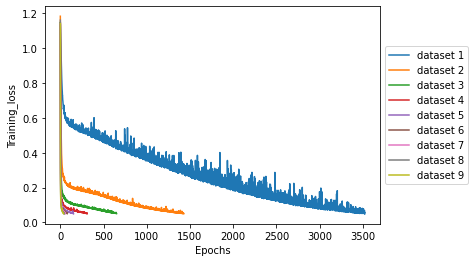

In [47]:
%matplotlib inline

fig = plt.figure()
for i,j in enumerate(train_loss_all):
    plt.plot(j,label ="dataset "+str(i+1))
    

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig("Figure.pdf")